# Spatial analysis of viral regions
**20201013, cmdoret**

I have extracted the positions of viral sequences in the A. castellanii assemblies of C3 and Neff strains and retrieved the contact profile of those regions. Visual inspection of the map hinted that some of the viral integration may have an insulating potential.

Here I quantify and visualise those contact profiles and inspect what is the genetic neighbourhood of those viral regions.

In [180]:
from os.path import join
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
DAT = join('..', '..', 'data', 'out')
VIRDAT = join(DAT, 'virus')
strains = ["C3", "Neff"]

# All data structs will be nested in a dictionary with strain as key.
# This makes generation harder to read, but querying more convenient
# {str: df}
borders = {s: pd.read_csv(join(VIRDAT, 'spatial', f'{s}_borders.tsv'), sep='\t') for s in strains}
# {str: {id: np.array[i,j]}}
pileups = {s: json.load(open(join(VIRDAT, 'spatial', f'{s}_borders.json'))) for s in strains}
for s in pileups.keys(): pileups[s] = {int(i): np.array(w) for i, w in pileups[s].items()}

# Make an empty 3D array of shape N_coords x height x width
# {str: np.array[i,j,k]}
win_arr = {s: np.zeros((len(pileups[s].items()), *pileups[s][0].shape)) for s in pileups.keys()}
# Fill the 3D array with windows values
for s in pileups.keys():
    for i, w in pileups[s].items():
        win_arr[s][i] = w

# Drop positions with NaN scores
for s in strains:
    valid_mask = ~np.isnan(borders[s].score)
    borders[s] = borders[s].loc[valid_mask, :]
    borders[s] = borders[s].reset_index(drop=True)
    win_arr[s] = win_arr[s][valid_mask, :, :]
    
# Load gene annotations
annot = {s: pd.read_csv(join(DAT, 'hgt', f'{s}_windows_hgt.tsv'), sep='\t') for s in strains}
for s in strains: annot[s]['LEN'] = annot[s].end - annot[s].start

# Load viral insertions coordinates
insert = {s: pd.read_csv(join(VIRDAT, f'{s}_summary.tsv'), sep='\t') for s in strains}


<IPython.core.display.Javascript object>


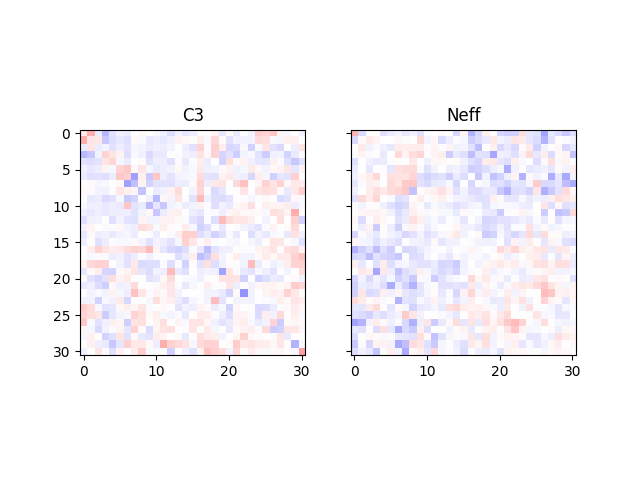

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [181]:
%matplotlib notebook
# Perhaps there is some faint insulation signal in Neff (losing with median)
# -> subset of insulating viral regions ?
def make_pileup(wins):
    if len(wins.shape) == 3:
        pileup = np.nanmean(wins, axis=0)
    else:
        pileup = wins
    pileup = np.nan_to_num(pileup)
    pileup = pileup + np.transpose(pileup) - np.diag(np.diag(pileup))
    return np.log2(pileup)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
for i, s in enumerate(strains):
    ax[i].imshow(make_pileup(win_arr[s]), cmap='bwr', vmin=-1, vmax=1)
    ax[i].set_title(s)

<IPython.core.display.Javascript object>


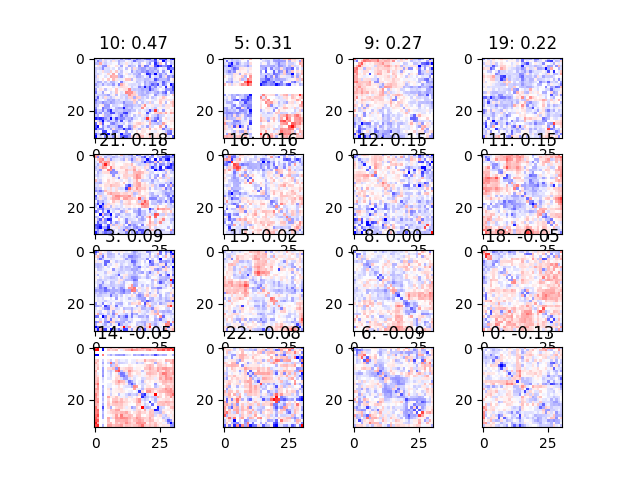

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()


In [3]:
%matplotlib notebook
# Windows 10, 9, 11 seem to have some insulation
# Misassemblies on windows 4, 20, 17
fig, ax = plt.subplots(4, 4)
for i, axi in zip(np.argsort(borders['C3'].score.values)[::-1][:16], ax.flat):
                    axi.imshow(make_pileup(win_arr['C3'][i, :, :]), cmap='bwr', vmin=-2, vmax=2)
                    axi.set_title(f"{i}: {borders['C3'].score[i]:.2f}")

<IPython.core.display.Javascript object>


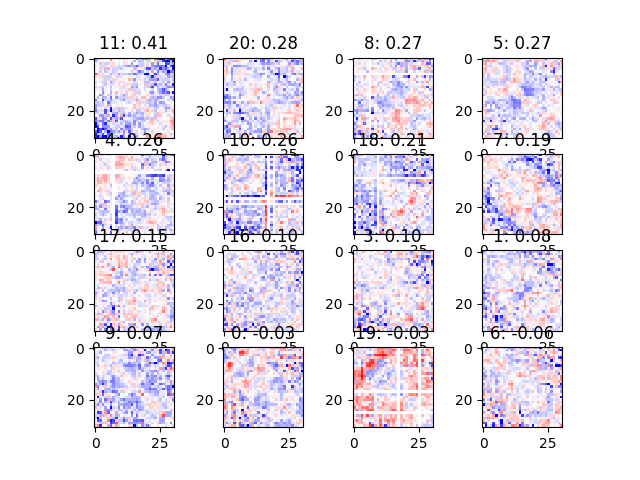

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()


In [182]:
%matplotlib notebook
# images 5, 8, 20 seem to have good insulation
fig, ax = plt.subplots(4, 4)
for i, axi in zip(np.argsort(borders['Neff'].score.values)[::-1][:16], ax.flat):
                    axi.imshow(make_pileup(win_arr['Neff'][i, :, :]), cmap='bwr', vmin=-2, vmax=2)
                    axi.set_title(f"{i}: {borders['Neff'].score[i]:.2f}")

### Manual inspection of viral regions
Here I look at the neighbourhood of viral regions that have strong insulation as reported by chromosight _and_ that look like borders.

<IPython.core.display.Javascript object>


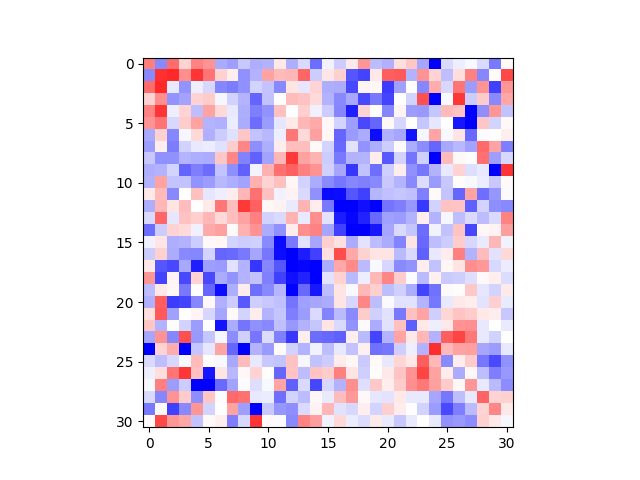

In [183]:
%matplotlib notebook

plt.imshow(make_pileup(win_arr['Neff'][5, :, :]), cmap='bwr', vmin=-1, vmax=1)

In [ ]:
#insul = {'C3': [9, 10, 11], 'Neff': [5, 8, 20]}
insul = {s: np.argsort(borders[s].score.values)[::-1][:16] for s in strains}



In [184]:
insert

{'C3':      scaffold_27  420312  420470  pandoravirus_inopinatum         1
 0    scaffold_28  322330  322486  pandoravirus_inopinatum  1.000000
 1    scaffold_53    6637    6793  pandoravirus_inopinatum  1.000000
 2    scaffold_13  102030  102186  pandoravirus_inopinatum  1.000000
 3    scaffold_29  154606  154855  pandoravirus_inopinatum  0.466887
 4    scaffold_17  450916  451009  pandoravirus_inopinatum  0.849462
 ..           ...     ...     ...                      ...       ...
 123  scaffold_33  150937  153258      pandoravirus_dulcis  0.018900
 124  scaffold_12  501557  501598      pandoravirus_dulcis  1.000000
 125   scaffold_7   54928   55056      pandoravirus_dulcis  0.320312
 126  scaffold_33   57578   60364      pandoravirus_dulcis  0.038406
 127  scaffold_27  956631  956872      pandoravirus_dulcis  0.224066
 
 [128 rows x 5 columns],
 'Neff':      scaffold_17  181104  181286  pandoravirus_inopinatum  0.465517
 0    scaffold_11   11118   11274  pandoravirus_inopinatum  0.

In [174]:

DIST = 10000
for s in strains: annot[s]['vir_region'] = 0

def get_neighbourhood(reg, ann, dist=1000):
    """Given a position, return annotations falling in the neighbourhood"""
    over_left  = (ann.start <= reg.end1   + dist) & (ann.start > reg.start1 - dist)
    over_right = (ann.end   >  reg.start1 - dist) & (ann.end   < reg.end1   + dist)
    same_chrom = ann.chrom == reg.chrom1
    return same_chrom & (over_left | over_right)
for s in strains:
    for i, reg in enumerate(insul[s]):
        border = borders[s].iloc[reg, :]
        reg_mask = get_neighbourhood(border, annot[s], dist=DIST)
        annot[s].loc[reg_mask, 'vir_region'] = i+1
    annot[s].vir_region = annot[s].vir_region.astype('category')
    annot[s]['isvir'] = (annot[s].vir_region != 0).astype('category')

In [175]:
for s in strains: print(f"{sum(annot[s].vir_region)} genes within {SIZE} of viral regions in {s}")

8673 genes within 1000 of viral regions in C3
4427 genes within 1000 of viral regions in Neff


In [176]:
annot['C3'].columns

Index(['chrom', 'start', 'end', 'geneID', 'HGT', 'NEXON', 'GC', 'GCSKEW',
       'ATSKEW', 'ENTRO', '2MER', '3MER', '4MER', 'LEN', 'vir_region',
       'isvir'],
      dtype='object')

<IPython.core.display.Javascript object>


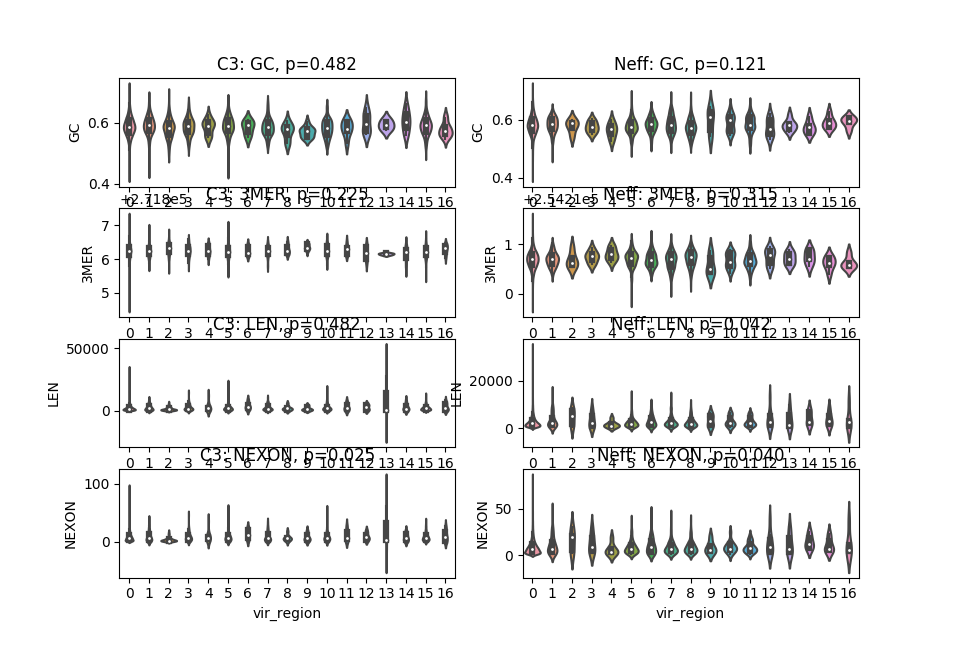

In [179]:
%matplotlib notebook
VAR = ['GC', '3MER', 'LEN', 'NEXON']
fig, axes = plt.subplots(len(VAR), 2)
for ax_row, var in zip(axes, VAR):
    for ax, s in zip(ax_row, strains):
        sns.violinplot(data=annot[s], x='vir_region', y=var, ax=ax)
        #sns.stripplot(data=annot[s].loc[annot[s].vir_region != 0, :], x='vir_region', y=var, hue='HGT', ax=ax, alpha=0.6)
        pval = ss.mannwhitneyu(annot[s].loc[annot[s].isvir==False, var], annot[s].loc[annot[s].isvir==True, var])[1]
        ax.set_title(f"{s}: {var}, p={pval:.3f}")

In [138]:
annot['C3'].loc[annot['C3'].isvir==True, :].sort_values('GCSKEW', ascending=False)

,chrom,start,end,geneID,HGT,NEXON,GC,GCSKEW,ATSKEW,ENTRO,2MER,3MER,4MER,LEN,vir_region,isvir
7504,scaffold_25,372398,372979,FUN_007760,0,1,0.536000,0.246269,0.146552,1.965351,1581743.328,271806.4278,32827.97959,581,8,True
9520,scaffold_30,256435,256812,FUN_009822,0,2,0.552000,0.202899,0.008929,1.975651,1581743.079,271806.4321,32828.00661,377,6,True
10883,scaffold_4,993141,1001877,FUN_011203,0,11,0.698556,0.199044,0.517208,1.792528,1581743.501,271804.9403,32827.60294,8736,12,True
10857,scaffold_4,910628,911791,FUN_011177,0,1,0.598500,0.188803,-0.048773,1.945119,1581743.488,271806.2259,32827.97301,1163,12,True
280,scaffold_1,863206,863771,FUN_000281,0,4,0.525000,0.188571,0.103158,1.980996,1581744.021,271806.5180,32828.03023,565,16,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,scaffold_25,343068,344968,FUN_007752,0,7,0.626500,-0.204005,-0.023634,1.926790,1581743.235,271806.0809,32827.93152,1900,8,True
5680,scaffold_20,124161,124987,FUN_005863,0,2,0.604000,-0.205298,-0.070707,1.948639,1581743.133,271806.1880,32827.94782,826,11,True
8710,scaffold_29,254644,255449,FUN_009010,0,4,0.470000,-0.236957,0.090670,1.973093,1581743.621,271806.6882,32827.99791,805,13,True
8159,scaffold_27,303143,303792,FUN_008449,0,2,0.619000,-0.243942,-0.086614,1.929840,1581742.752,271805.9925,32827.92428,649,7,True
